In [1]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

def do_rollout_pert(env, policy, initial_pos, num_steps=10):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = my_reset(env, initial_pos)
    done = False

    for cur_step in range(num_steps):
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew


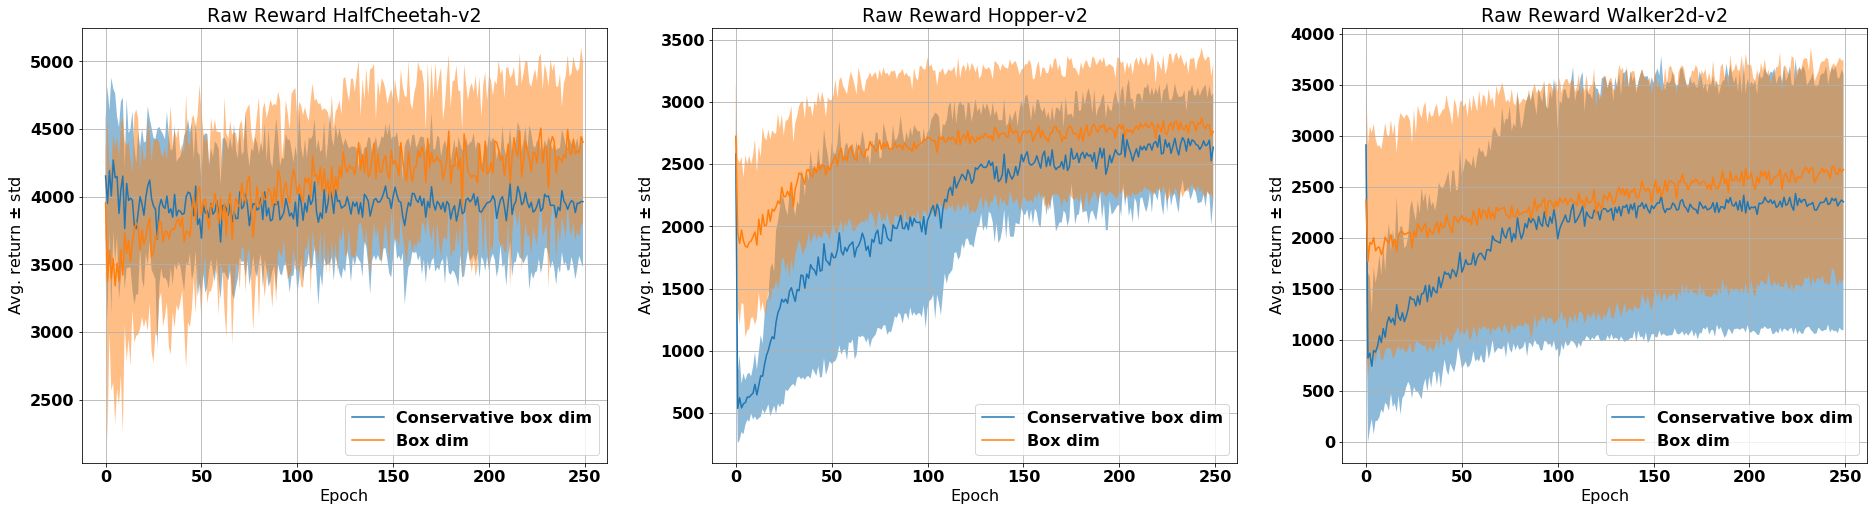

In [2]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]
init_names = ["identity", "madodiv", "identity"]

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, len(env_names), figsize=(32,8))

i = 0 
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    ax[i].plot(means.T)
    ax[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        ax[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    ax[i].set_title(f"Raw Reward {env_name}")
    ax[i].set_ylabel(r"Avg. return $\pm$ std")
    ax[i].set_xlabel(r"Epoch")
    ax[i].grid()
    i+=1
    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()
    

In [3]:
env_name = "HalfCheetah-v2"
env = gym.make(env_name)
data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict

init_data = torch.load(f"./data17/{env_name}.xr")
init_pol_dict = init_data.policy_dict
policy_dict['identity'] = init_pol_dict['identity']


exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])
mesh_sizes_dict = {}

running build_ext


In [ ]:
# HalfCheetah-v2
post_names = ['identity', 'mdim_div']
num_seeds = 10
num_runs = 10
     
eigs = xr.DataArray(np.zeros((2, num_seeds, num_runs, 17), dtype=np.complex),
                dims = ("post", "seed", "run", "eig_vals"),
                coords = {"post": post_names})

eigs_bc = xr.DataArray(np.zeros((2, num_seeds, num_runs, 17), dtype=np.complex),
                dims = ("post", "seed", "run", "eig_vals"),
                coords = {"post": post_names})


for post in post_names:
    for seed in range(num_seeds):
        for run in range(num_runs):
            #post = 'identity'; seed = 1

            policy = policy_dict[post][seed]

            def my_reset(env, point):
                env.reset()
                qpos = np.concatenate((np.array([0.0]), point[:8]))
                qvel = point[8:]
                env.unwrapped.set_state(qpos, qvel)
                return env.unwrapped._get_obs()


            nom_obs, nom_acts, nom_rews, _ = do_long_rollout(env,policy,10000)

            nominal_state = nom_obs[500]

            obs, acts, rews = do_rollout_pert(env, policy, nominal_state, num_steps=11)
            cmp_point = obs[-1]

            delta = .1

            initial_conditions = []
            for i,s in enumerate(nominal_state):
                nominal_state_p = np.copy(nominal_state)
                nominal_state_m = np.copy(nominal_state)
                nominal_state_p[i] += delta
                nominal_state_m[i] -= delta

                initial_conditions.append((nominal_state_p, nominal_state_m))


            eig_mat = np.zeros((17,17))
            eig_mat_bc = np.zeros((17,17))

            for i, initial_condition in enumerate(initial_conditions):
                init_state_p , init_state_m = initial_condition
                rollout_obs_p, rollout_acts_p, rollout_rews_p = do_rollout_pert(env,policy, init_state_p, num_steps=101)
                rollout_obs_m, rollout_acts_m, rollout_rews_m = do_rollout_pert(env,policy, init_state_m, num_steps=101)
                
                diffs = np.abs(rollout_obs_p[-10:].numpy()-rollout_obs_m[-10:].numpy()) - np.abs(init_state_p - init_state_m)
                i_min = np.argmin(np.linalg.norm(diffs, axis=1)) 
                
                eig_mat_bc[:,i] = diffs[i_min]
                eig_mat[:,i] = diffs[-1]

                
                #eig_mat[:,i] = np.abs(rollout_obs_p[-1].numpy()-rollout_obs_m[-1].numpy())
            w,v = np.linalg.eig(eig_mat) 
            eigs.loc[post][seed][run] = copy.copy(w)
            
            w,v = np.linalg.eig(eig_mat_bc) 
            eigs_bc.loc[post][seed][run] = copy.copy(w)

                

In [18]:
v,w = np.linalg.eig(eig_mat)
print(v)
np.abs(v) > 1

[13.65878837+0.j          2.0340071 +1.61116418j  2.0340071 -1.61116418j
  2.42504349+0.j         -2.57430154+0.j          0.409091  +0.77301494j
  0.409091  -0.77301494j -0.93674719+0.j         -0.50458817+0.09234328j
 -0.50458817-0.09234328j  0.11854139+0.22810006j  0.11854139-0.22810006j
  0.11260666+0.04233261j  0.11260666-0.04233261j  0.04112611+0.j
 -0.10600421+0.j         -0.14916812+0.j        ]


array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [117]:
for name in post_names:
    means = eigs.mean(dim=('seed', 'run')).loc[name]
    stds = eigs.std(dim=('seed', 'run')).loc[name]
    print(f"{name} mean: {means}, std: {stds}")

identity mean: <xarray.DataArray (eig_vals: 17)>
array([10.13403678+0.j        , -0.07685987+0.45245821j,
       -0.20954066-0.12252292j,  0.02013209+0.08368449j,
       -0.04322399-0.14967897j, -0.22760309-0.07956615j,
       -0.22487893+0.02907697j, -0.16366982-0.10194586j,
       -0.22078628-0.01619714j, -0.19442335-0.02293969j,
       -0.14546589-0.00830682j, -0.17989732-0.01862375j,
       -0.20241608-0.02134299j, -0.18335215+0.01244683j,
       -0.20169265-0.02377677j, -0.19109187-0.00385835j,
       -0.19197181-0.00890708j])
Coordinates:
    post     <U8 'identity'
Dimensions without coordinates: eig_vals, std: <xarray.DataArray (eig_vals: 17)>
array([7.15568325, 3.17903534, 2.18138062, 1.58992346, 1.33210703,
       1.04177867, 0.77768687, 0.64150539, 0.53996697, 0.43128343,
       0.32332734, 0.24061625, 0.18523217, 0.12027457, 0.10058276,
       0.07988292, 0.05936081])
Coordinates:
    post     <U8 'identity'
Dimensions without coordinates: eig_vals
mdim_div mean: <xarray.Da

In [ ]:
post = 'mdim_div'; seed = 1

if post not in mesh_sizes_dict:
    mesh_sizes_dict[post] = {}

policy = policy_dict[post][seed]
mesh = BoxMesh(.2)
mesh_sizes = []

#init_states = np.linspace(-.3, .3, num=2)
#init_conditions = np.meshgrid(*[init_states]*17)

In [ ]:
for i in range(1000000):
    obs, acts, rews, mesh = do_rollout_mesh(env, policy, mesh)
    mesh_sizes.append(len(mesh))
plt.plot(mesh_sizes)
mesh_sizes_dict[post][seed] = mesh_sizes

In [ ]:
plt.plot(mesh_sizes_dict['identity'][1])
plt.plot(mesh_sizes_dict['mdim_div'][1])